In [1]:
# 1️⃣ PyTorch 2.0 + CUDA 11.8 (Colab ortamına uygun)
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html

# 2️⃣ PyG bağımlılıkları
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

# 3️⃣ PyTorch Geometric ve Temporal
!pip install torch-geometric
!pip install torch-geometric-temporal


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 581.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu124
    Uninstalling torch-2.5.1+cu124:
      Successfully uninstalled torch-2.5.1+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu124
    Uninstalling torchvision-0.20.1+cu124:
      Successfully uninstalled torchvision-0.20.1+cu124
  Attempting uninstall: 

In [2]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# ===============================
# 📁 3. Verilerin yüklenmesi
# ===============================
DATA_DIR = "/content/drive/MyDrive/SNA_PROJECT"

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU
import torch.nn as nn
import numpy as np

# Veri dosyalarını yükle
labeled_df = pd.read_csv(f"{DATA_DIR}/labeled-input_A.csv.xls", header=None,
                         names=["source", "target", "edge_type", "start", "end", "label"])
labeled_input_only = labeled_df.drop(columns=["label"])
node_features_df = pd.read_csv(f"{DATA_DIR}/node_features.csv.gz", compression="gzip", header=None)
edge_type_features_df = pd.read_csv(f"{DATA_DIR}/edge_type_features.csv.gz", compression="gzip", header=None)
edges_df = pd.read_csv(f"{DATA_DIR}/edges_train_A.csv.gz", compression="gzip", nrows=10_000_000, header=None,
                       names=["source", "target", "edge_type", "timestamp"])

# Verilerin örneklerini yazdır
print("\n🔎 Sample Rows from Data Files:")
print("\n🟦 edges_train_A.csv.gz:")
print(edges_df.head(5))

print("\n🟩 edge_type_features.csv.gz:")
print(edge_type_features_df.head(5))

print("\n🟨 node_features.csv.gz:")
print(node_features_df.head(5))

# Node feature boyutu
print("🧩 Node Feature Shape:", node_features_df.shape)
print(node_features_df.head())

# Null değer kontrolü
print("🚫 Null değer var mı?:", node_features_df.isnull().any().any())

# -1 değerlerini sıfıra çevir
node_features_df[node_features_df < 0] = 0

# Geçerli düğümleri içeren edge'ler
valid_node_ids = set(range(len(node_features_df)))
edges_df = edges_df[
    edges_df["source"].isin(valid_node_ids) & edges_df["target"].isin(valid_node_ids)
].reset_index(drop=True)


# Kontrol: boyut ve ilk birkaç satır
labeled_input_only_shape = labeled_input_only.shape
labeled_input_only_preview = labeled_input_only.head()

# Kaydetmek istersen: test seti gibi davranacak
test_input_path = (f"{DATA_DIR}/labeled_input_for_prediction.csv")
labeled_input_only.to_csv(test_input_path, index=False)

labeled_input_only_shape, labeled_input_only_preview, test_input_path



🔎 Sample Rows from Data Files:

🟦 edges_train_A.csv.gz:
   source  target  edge_type   timestamp
0     106   28905         96  1413662400
1     211   14601         32  1413662400
2    1355   45804         65  1413662400
3    2540   60948         69  1413662400
4    2867   28905         74  1413662400

🟩 edge_type_features.csv.gz:
   0    1   2   3
0  0   56  16  32
1  1  179  15  70
2  2   65   6  62
3  3  104  12  86
4  4  114   3  20

🟨 node_features.csv.gz:
    0   1  2  3  4  5    6  7   8
0   2  29 -1 -1 -1 -1    9 -1  -1
1   5  29 -1 -1 -1 -1   -1 -1  20
2  11  11 -1 -1 -1 -1   -1 -1  20
3  16  13 -1 -1 -1 -1  155 -1  20
4  19  -1 -1 -1 -1 -1   40 -1  -1
🧩 Node Feature Shape: (19442, 9)
    0   1  2  3  4  5    6  7   8
0   2  29 -1 -1 -1 -1    9 -1  -1
1   5  29 -1 -1 -1 -1   -1 -1  20
2  11  11 -1 -1 -1 -1   -1 -1  20
3  16  13 -1 -1 -1 -1  155 -1  20
4  19  -1 -1 -1 -1 -1   40 -1  -1
🚫 Null değer var mı?: False


((8197, 5),
    source  target  edge_type       start         end
 0      30   48382        151  1494663180  1494794383
 1     106    8540         78  1494635755  1494835958
 2     106    8540        149  1498383835  1498499059
 3     106   20816         65  1494661105  1494827593
 4     106   28905         19  1494634666  1494767554,
 '/content/drive/MyDrive/SNA_PROJECT/labeled_input_for_prediction.csv')

In [5]:
print("🧩 Node Feature Shape:", node_features_df.shape)
print(node_features_df.head())

print("✅ node_features_df types:", node_features_df.dtypes)
print("🚫 Null değer var mı?:", node_features_df.isnull().any().any())


🧩 Node Feature Shape: (19442, 9)
    0   1  2  3  4  5    6  7   8
0   2  29  0  0  0  0    9  0   0
1   5  29  0  0  0  0    0  0  20
2  11  11  0  0  0  0    0  0  20
3  16  13  0  0  0  0  155  0  20
4  19   0  0  0  0  0   40  0   0
✅ node_features_df types: 0    int64
1    int64
2    int64
3    int64
4    int64
5    int64
6    int64
7    int64
8    int64
dtype: object
🚫 Null değer var mı?: False


In [6]:
# Dataset sınıfı
class TemporalGraphDataset(Dataset):
    def __init__(self, edge_df, node_feat_df, edge_type_feat):
        self.timesteps = sorted(edge_df["timestamp"].unique())
        self.edge_data = edge_df
        self.node_features = torch.tensor(node_feat_df.values, dtype=torch.float)
        self.edge_type_feat = torch.tensor(edge_type_feat.values, dtype=torch.float)

    def __len__(self):
        return len(self.timesteps)

    def __getitem__(self, idx):
        t = self.timesteps[idx]
        sub_edges = self.edge_data[self.edge_data["timestamp"] == t]
        src = torch.tensor(sub_edges["source"].values, dtype=torch.long)
        dst = torch.tensor(sub_edges["target"].values, dtype=torch.long)
        edge_index = torch.stack([src, dst])
        edge_types = torch.tensor(sub_edges["edge_type"].values, dtype=torch.long)

        # edge_type özelliklerinin ortalamasını kullan
        edge_weights = self.edge_type_feat[edge_types].mean(dim=1)

        return self.node_features, edge_index, edge_weights


In [7]:
# Model ve ayarlar
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_NODE_FEATURES = node_features_df.shape[1]

# Hiperparametreler
HIDDEN_DIM = 64
EPOCHS = 15
LEARNING_RATE = 0.0003  # Öğrenme oranını düşürdük

# GConvGRU modelini yeniden tanımla
model = GConvGRU(in_channels=node_features_df.shape[1], out_channels=HIDDEN_DIM, K=2).to(DEVICE)

# Daha güçlü predictor mimarisi
predictor = nn.Sequential(
    nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM * 4),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout oranını 0.5'e yükselttik
    nn.Linear(HIDDEN_DIM * 4, HIDDEN_DIM * 2),
    nn.ReLU(),
    nn.Linear(HIDDEN_DIM * 2, 1)
).to(DEVICE)

# Dengesiz sınıflar için loss (pozitif sınıf az olduğu için ağırlıklandırma)
pos_weight = torch.tensor([5.0], device=DEVICE)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizasyon
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()),
    lr=LEARNING_RATE
)

# Öğrenme oranını dinamik şekilde ayarlamak için scheduler ekliyoruz
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Eğitim
dataset = TemporalGraphDataset(edges_df, node_features_df, edge_type_features_df)
loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [8]:
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    skipped_batches = 0
    debug_count = 0

    for node_feat, edge_index, edge_weight in loader:
        node_feat = node_feat.squeeze(0).to(DEVICE)
        edge_index = edge_index.squeeze(0).to(DEVICE)
        edge_weight = edge_weight.squeeze(0).to(DEVICE)

        if edge_index.max().item() >= node_feat.shape[0] or edge_index.shape[1] != edge_weight.shape[0]:
            skipped_batches += 1
            continue

        h = model(node_feat, edge_index, edge_weight)

        # Pozitif örnekler
        pos_src = edge_index[0].cpu().detach().tolist()
        pos_dst = edge_index[1].cpu().detach().tolist()
        pos_edges = set(zip(pos_src, pos_dst))

        if len(pos_edges) == 0:
            skipped_batches += 1
            continue

        # Negatif örnekleme
        all_nodes = list(set(pos_src).union(set(pos_dst)))
        neg_edges = set()
        tries = 0
        while len(neg_edges) < len(pos_edges) and tries < len(pos_edges) * 10:
            u, v = np.random.choice(all_nodes, 2, replace=False)
            if (u, v) not in pos_edges and (v, u) not in pos_edges:
                neg_edges.add((u, v))
            tries += 1

        if len(neg_edges) == 0:
            skipped_batches += 1
            continue

        def edge_embeddings(edge_list):
            src_idx = torch.tensor([e[0] for e in edge_list], dtype=torch.long, device=DEVICE)
            dst_idx = torch.tensor([e[1] for e in edge_list], dtype=torch.long, device=DEVICE)
            return torch.cat([h[src_idx], h[dst_idx]], dim=1)

        x_pos = edge_embeddings(pos_edges)
        x_neg = edge_embeddings(neg_edges)

        x_total = torch.cat([x_pos, x_neg], dim=0)
        y_total = torch.cat([torch.ones(x_pos.size(0), device=DEVICE),
                             torch.zeros(x_neg.size(0), device=DEVICE)])

        y_pred = predictor(x_total).squeeze()
        loss = loss_fn(y_pred, y_total)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    # Öğrenme oranını düşür
    scheduler.step()

    print(f"\n✅ Epoch {epoch+1} | Loss: {total_loss:.4f} | Skipped Batches: {skipped_batches}")


✅ Epoch 1 | Loss: 10124.6765 | Skipped Batches: 0

✅ Epoch 2 | Loss: 10088.9152 | Skipped Batches: 0

✅ Epoch 3 | Loss: 10074.5380 | Skipped Batches: 0

✅ Epoch 4 | Loss: 10068.0816 | Skipped Batches: 0

✅ Epoch 5 | Loss: 10066.8215 | Skipped Batches: 0

✅ Epoch 6 | Loss: 10061.8214 | Skipped Batches: 0

✅ Epoch 7 | Loss: 10050.7566 | Skipped Batches: 0

✅ Epoch 8 | Loss: 10048.7002 | Skipped Batches: 0

✅ Epoch 9 | Loss: 10043.4508 | Skipped Batches: 0

✅ Epoch 10 | Loss: 10043.9323 | Skipped Batches: 0

✅ Epoch 11 | Loss: 10039.7093 | Skipped Batches: 0

✅ Epoch 12 | Loss: 10039.8037 | Skipped Batches: 0

✅ Epoch 13 | Loss: 10025.3616 | Skipped Batches: 0

✅ Epoch 14 | Loss: 10029.0154 | Skipped Batches: 0

✅ Epoch 15 | Loss: 10030.4381 | Skipped Batches: 0


In [11]:
# Modeli evaluation moduna al
model.eval()
predictor.eval()

# Son zaman adımındaki graph ile düğüm embedding'lerini üret
with torch.no_grad():
    last_t = edges_df["timestamp"].max()
    final_edges = edges_df[edges_df["timestamp"] == last_t]

    src = torch.tensor(final_edges["source"].values, dtype=torch.long).to(DEVICE)
    dst = torch.tensor(final_edges["target"].values, dtype=torch.long).to(DEVICE)
    edge_index = torch.stack([src, dst])

    edge_types = torch.tensor(final_edges["edge_type"].values, dtype=torch.long).to(DEVICE)
    edge_type_tensor = torch.tensor(edge_type_features_df.values, dtype=torch.float).to(DEVICE)
    edge_weights = edge_type_tensor[edge_types].mean(dim=1)

    # Tüm düğümler için embedding
    node_features_tensor = torch.tensor(node_features_df.values, dtype=torch.float).to(DEVICE)
    final_embeddings = model(node_features_tensor, edge_index, edge_weights)

# Tahminleri hesapla
predictions = []
predicted_labels = []

with torch.no_grad():
    for _, row in labeled_input_only.iterrows():
        s, t = int(row["source"]), int(row["target"])
        if s >= final_embeddings.shape[0] or t >= final_embeddings.shape[0]:
            prob = 0.0
        else:
            h_src = final_embeddings[s]
            h_tgt = final_embeddings[t]
            edge_feat = torch.cat([h_src, h_tgt], dim=0)
            prob = torch.sigmoid(predictor(edge_feat)).item()
        predictions.append(prob)
        predicted_labels.append(int(prob >= 0.5))

labeled_input_only["predicted_probability"] = predictions
labeled_input_only["predicted_label"] = predicted_labels
labeled_input_only["true_label"] = labeled_df["label"]

output_path = f"{DATA_DIR}/output_A.csv"
labeled_input_only.to_csv(output_path, index=False)

In [12]:
df = pd.read_csv(f"{DATA_DIR}/output_A.csv")
print(df["predicted_probability"].describe())


count    8197.000000
mean        0.029708
std         0.150652
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.894327
Name: predicted_probability, dtype: float64


In [13]:
with torch.no_grad():
    h = model(node_features_tensor, edge_index, edge_weights)
    print("Embedding std:", h.std().item())


Embedding std: 0.8413088321685791


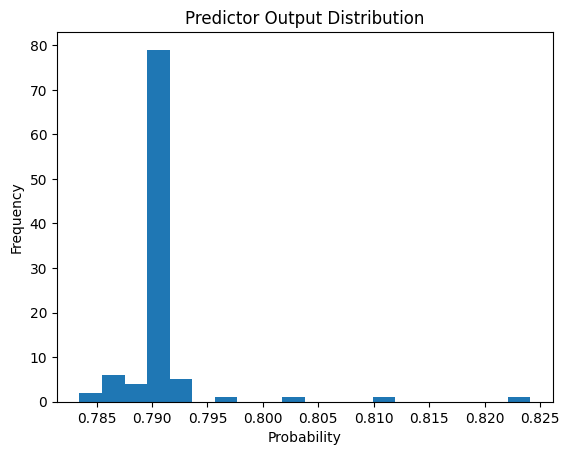

In [14]:
# Rastgele 100 edge örneğiyle tahmin skorlarını dağıt
import numpy as np

samples = []
with torch.no_grad():
    for _ in range(100):
        s, t = np.random.choice(final_embeddings.shape[0], 2, replace=False)
        h_src = final_embeddings[s]
        h_tgt = final_embeddings[t]
        edge_feat = torch.cat([h_src, h_tgt], dim=0)
        prob = torch.sigmoid(predictor(edge_feat)).item()
        samples.append(prob)

import matplotlib.pyplot as plt
plt.hist(samples, bins=20)
plt.title("Predictor Output Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()


In [15]:
import pandas as pd

# Etiket dosyasını tüm sütunlarla yükle
df = pd.read_csv(f"{DATA_DIR}/labeled-input_A.csv.xls", header=None)

# İlk 10 satırı ve tüm kolonları göster
df.head(10)


,0,1,2,3,4,5
0,30,48382,151,1494663180,1494794383,1
1,106,8540,78,1494635755,1494835958,1
2,106,8540,149,1498383835,1498499059,0
3,106,20816,65,1494661105,1494827593,1
4,106,28905,19,1494634666,1494767554,1
5,106,28905,171,1497643549,1497824035,0
6,106,28905,242,1494590891,1494815231,1
7,106,60168,33,1494594182,1494816639,1
8,106,64560,74,1494654474,1494772472,1
9,106,51786,108,1494597706,1494766101,0


In [16]:
# ROC AUC Hesapla
from sklearn.metrics import roc_auc_score

labeled_df = pd.read_csv(f"{DATA_DIR}/labeled-input_A.csv.xls", header=None)
labeled_df = labeled_df[[0, 1, 5]]
labeled_df.columns = ["source", "target", "label"]

output_df = pd.read_csv(f"{DATA_DIR}/output_A.csv")
merged_df = pd.merge(output_df, labeled_df, on=["source", "target"], how="inner")

binary_df = merged_df[merged_df["label"].isin([0, 1])]

if binary_df.empty:
    auc_score = None
else:
    y_true = binary_df["label"].astype(int)
    y_score = binary_df["predicted_probability"].astype(float)
    auc_score = roc_auc_score(y_true, y_score)

print("✅ Doğru ROC AUC:", auc_score)



✅ Doğru ROC AUC: 0.5050202586360188
